# Preprocessing Overview — Worm Neuron
#### Preprocessing Overview — Worm Neuron
Input dataset: dataset/worm_neuron_data.h5 (update the path if yours differs)
This HDF5 file provides the raw count matrix X, cell_name (cell IDs), gene_name (gene symbols), and Y (cell-type labels). The goal of this notebook is to clean, normalize, and feature-select the data, then compute a low-dimensional embedding and save a standardized .h5ad for downstream clustering (KMeans, DEC, scDCC).

1. Imports & Data Loading
2. Build AnnData Object
3. Visual QC (Quick Inspection)
4. QC Filtering & Thresholds
5. Normalization & Log Transform
6. Highly Variable Genes (HVGs) + Forced Neuronal Markers (e.g., unc-17, cho-1, eat-4, dat-1, unc-47 to preserve cholinergic/glutamatergic/dopaminergic/GABAergic signals)
7. Cell Count:
8. Save Preprocessed Object

Overview:
This notebook cleans the Worm Neuron dataset, normalizes counts, selects informative genes—while explicitly retaining key neuronal lineage markers—and prepares a compact, well-behaved representation saved as an .h5ad. It serves as the common, reproducible preprocessing stage feeding your model-comparison notebook.

## 1. Imports & Data Loading:
This block sets up the environment and loads the raw Worm Neuron dataset from an HDF5 file. The imports pull in the single-cell toolkit (Scanpy/AnnData), the scientific stack (NumPy/Pandas), plotting (Matplotlib/Seaborn), and ML/deep-learning utilities (scikit-learn/PyTorch) that will be used later. The h5py.File call reads the four key arrays: X (raw counts, cells×genes), cell_name and gene_name (identifiers), and Y (cell-type labels). Because HDF5 often stores strings as bytes, the code converts identifiers and (if needed) labels to proper Python strings, leaving numeric labels as numbers. This prepares the raw data in memory for constructing an AnnData object and running downstream QC and preprocessing.

In [1]:
# -------- Imports and Setup --------
import scanpy as sc
import numpy as np
import torch, torch.nn as nn, torch.nn.functional as F, torch.optim as optim
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score, adjusted_mutual_info_score
from scipy.optimize import linear_sum_assignment
import random
from itertools import combinations, product
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
import anndata as ad
import pandas as pd


# ---------- Load raw Mouse Bladder dataset (.h5) ---------
# The file stores:
#   - X: raw count matrix (cells x genes)
#   - cell_name: per-cell identifiers
#   - gene_name: per-gene identifiers
#   - Y: cell-type labels (string or numeric)
with h5py.File("dataset/Worm_neuron_raw_data.h5", "r") as f:
    X = f["X"][:] # Expression counts (dense array)

    # Decode identifiers; HDF5 may store as bytes -> convert to str
    cell_names = f["cell_name"][:].astype(str)
    gene_names = f["gene_name"][:].astype(str)

    # Labels can be stored as bytes (S) / object (O) or numeric; handle both
    if f["Y"].dtype.kind in {"S", "O"}:
        labels = f["Y"][:].astype(str)
    else:
        labels = f["Y"][:]

## 2. Build AnnData Object:
This code creates an AnnData object, which is a common data structure used in Scanpy for storing and processing single-cell RNA-seq data.
We load the expression matrix X along with cell metadata (names and cell type labels) and gene metadata (gene names) into the obs and var attributes, respectively.
We then set the observation (obs_names) and variable (var_names) indices explicitly to ensure correct alignment during analysis. Finally, we print a summary of the AnnData object and preview the first few rows of cell metadata.

In [2]:
# Create an AnnData object to store the single-cell RNA-seq data
adata = ad.AnnData(
    X=X, # Expression matrix (cells × genes)

    # Metadata for observations (cells)
    obs=pd.DataFrame({"cell_name": cell_names, "cell_type": labels}, index=cell_names),

    # Metadata for variables (genes)
    var=pd.DataFrame({"gene_name": gene_names}, index=gene_names)
)

# Explicitly set variable and observation names (for consistency in downstream processing)
adata.var_names = gene_names
adata.obs_names = cell_names

print(adata)
adata.obs.head()

AnnData object with n_obs × n_vars = 4186 × 13488
    obs: 'cell_name', 'cell_type'
    var: 'gene_name'


,cell_name,cell_type
cele-001-001.AACTACGGCT,cele-001-001.AACTACGGCT,1.0
cele-001-001.GAGGCTTATT,cele-001-001.GAGGCTTATT,1.0
cele-001-001.CTGATCGACC,cele-001-001.CTGATCGACC,2.0
cele-001-001.CCTACGGCAA,cele-001-001.CCTACGGCAA,1.0
cele-001-001.CGCTAACCGT,cele-001-001.CGCTAACCGT,3.0


## 3. Visual QC 

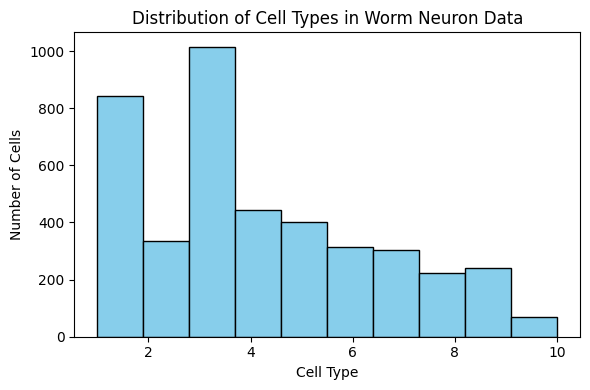

In [3]:
plt.figure(figsize=(6,4))
plt.hist(adata.obs['cell_type'], bins=len(np.unique(adata.obs['cell_type'])), color='skyblue', edgecolor='k')
plt.xlabel('Cell Type')
plt.ylabel('Number of Cells')
plt.title('Distribution of Cell Types in Worm Neuron Data')
plt.tight_layout()
plt.show()

## 4. QC Filtering & Thresholds:
This section is performing quality control on the single-cell RNA-seq dataset:
* Filters low-quality cells (low gene counts, high mitochondrial content).
* Removes rare genes detected in too few cells.
* Uses QC plots to visually assess filtering thresholds.
* Removes outliers to ensure only high-quality cells remain for analysis.

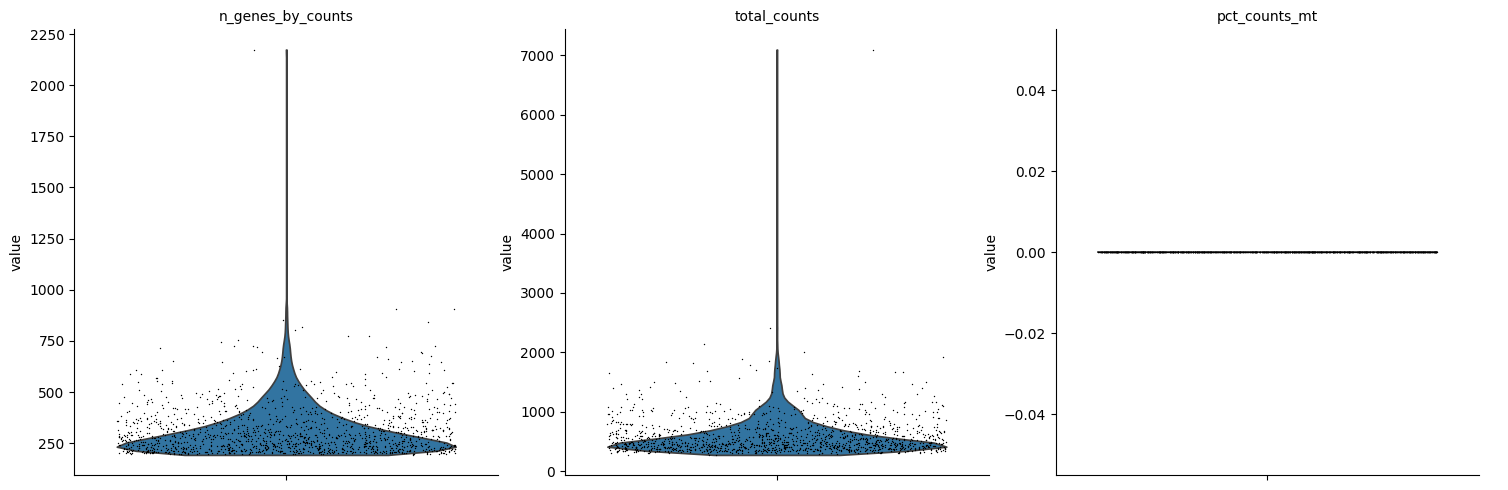

In [4]:
# --- Basic filtering ---
# Keep cells that have at least 200 detected genes
sc.pp.filter_cells(adata, min_genes=200)

# Keep genes that are detected in at least 3 cells
sc.pp.filter_genes(adata, min_cells=3)

# --- Identify mitochondrial genes ---
# Create a boolean mask for mitochondrial genes (gene names start with 'MT-')
adata.var['mt'] = adata.var_names.str.upper().str.startswith('MT-')

# Calculate quality control (QC) metrics
# qc_vars=['mt'] ensures mitochondrial gene percentages are included
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], inplace=True)

# --- Visualize QC metrics ---
# Violin plots showing:
# - Number of genes detected per cell (n_genes_by_counts)
# - Total counts per cell (total_counts)
# - Percentage of mitochondrial counts (pct_counts_mt)
sc.pl.violin(
    adata,          
    ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], 
    jitter=0.4, 
    multi_panel=True
)
plt.show()

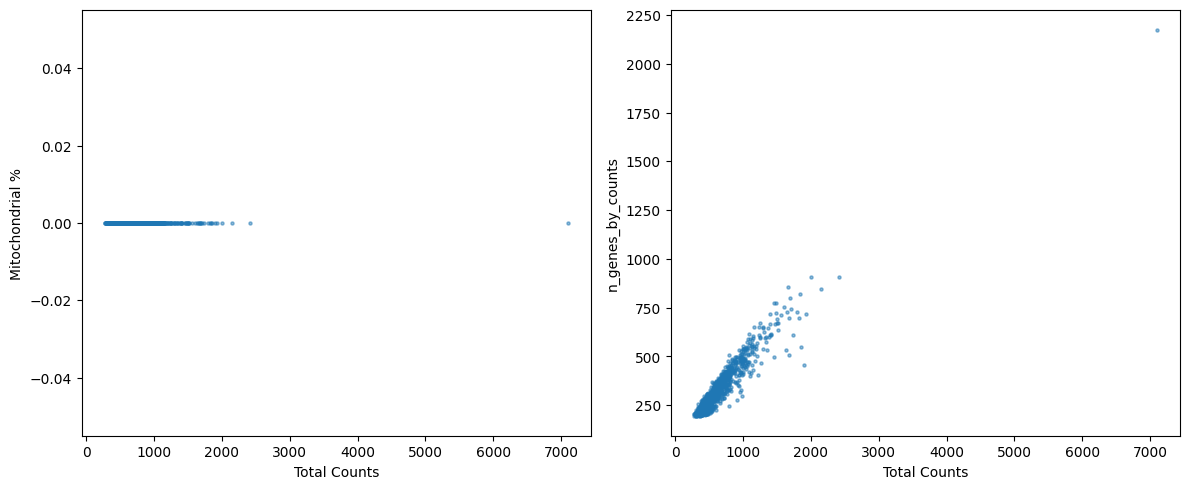

In [5]:
# Scatter plots to explore relationships between QC metrics
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Total counts vs mitochondrial percentage
axs[0].scatter(adata.obs['total_counts'], adata.obs['pct_counts_mt'], s=5, alpha=0.5)
axs[0].set_xlabel('Total Counts'); axs[0].set_ylabel('Mitochondrial %')

# Total counts vs number of genes detected
axs[1].scatter(adata.obs['total_counts'], adata.obs['n_genes_by_counts'], s=5, alpha=0.5)
axs[1].set_xlabel('Total Counts'); axs[1].set_ylabel('n_genes_by_counts')
plt.tight_layout(); plt.show()

# Determine cutoffs for unusually high counts or genes (remove outliers)
gene_cutoff = np.percentile(adata.obs['n_genes_by_counts'], 98)
count_cutoff = np.percentile(adata.obs['total_counts'], 98)

# Apply cutoffs
adata = adata[adata.obs['n_genes_by_counts'] < gene_cutoff, :]
adata = adata[adata.obs['total_counts'] < count_cutoff, :]

/var/folders/jv/npx4rz354hb929cw_lzlxh_80000gn/T/ipykernel_81493/1784738465.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[0].legend()


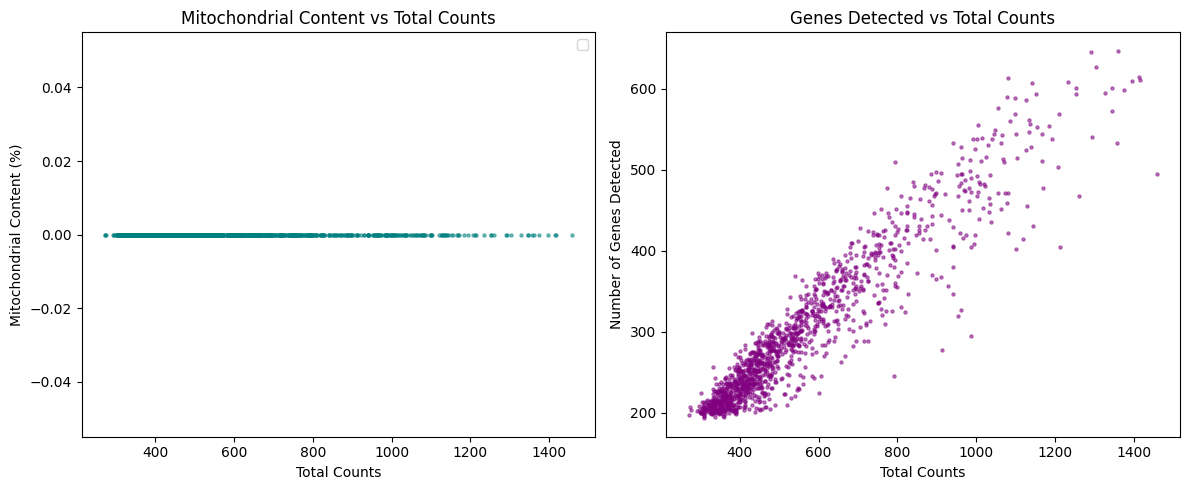

In [6]:
# --- Visualize filtered dataset ---
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Mitochondrial content vs total counts
axs[0].scatter(adata.obs['total_counts'], adata.obs['pct_counts_mt'], s=5, alpha=0.5, color='teal')
axs[0].set_xlabel('Total Counts')
axs[0].set_ylabel('Mitochondrial Content (%)')
axs[0].set_title('Mitochondrial Content vs Total Counts')
axs[0].legend()

# Number of genes detected vs total counts
axs[1].scatter(adata.obs['total_counts'], adata.obs['n_genes_by_counts'], s=5, alpha=0.5, color='purple')
axs[1].set_xlabel('Total Counts')
axs[1].set_ylabel('Number of Genes Detected')
axs[1].set_title('Genes Detected vs Total Counts')

plt.tight_layout()
plt.show()

## 5. Normalization & Log Transform:
This step scales and stabilizes the data before feature selection and clustering. Without this, cells with more reads or extremely high gene counts could dominate the analysis.

In [7]:
# --- Normalize the data ---
# Normalize total counts per cell so that each cell has the same total count (target_sum = 10,000)
# This ensures comparability between cells by removing sequencing depth bias
sc.pp.normalize_total(adata, target_sum=1e4)

# --- Log-transform the data ---
# Apply log(x + 1) transformation to reduce the impact of highly expressed genes
# This makes the data more normally distributed and suitable for downstream analysis
sc.pp.log1p(adata)

/opt/anaconda3/lib/python3.13/site-packages/scanpy/preprocessing/_normalization.py:269: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


## 6. Highly Variable Genes (HVGs) + Forced Neuronal Markers (e.g., unc-17, cho-1, eat-4, dat-1, unc-47 to preserve cholinergic/glutamatergic/dopaminergic/GABAergic signals)

* We load a BioMart-derived gene mapping table to standardize gene names, then define a curated list of C. elegans neuron markers (pan-neuronal and transmitter-specific). Later, these markers are force-kept during HVG selection so that key neuronal identities aren’t lost due to purely variance-based filtering.
* Also, maps your curated C. elegans neuronal marker symbols to WBGene IDs using the BioMart table, intersects them with the genes present in the dataset, and then forces those markers to be included in the HVG set. After computing HVGs with the Seurat method, it updates the HVG mask to include any available markers, subsets the data to HVGs + markers, and finally re-normalizes and log-transforms the subset so it’s ready for downstream embedding and clustering.


In [8]:
# Load gene mapping (BioMart export)
gene_map = pd.read_csv("mart_export.txt")
gene_map = gene_map[gene_map['Gene name'].notnull()]

# --- C. elegans neuronal marker genes ---
# Mix of pan-neuronal (e.g., rab-3, snb-1, unc-119) and neurotransmitter-specific markers:
#   - Cholinergic: unc-17, cha-1
#   - Glutamatergic: eat-4
#   - GABAergic: unc-47, unc-25
#   - Dopaminergic / sensory / synaptic components: glr-1, acr-2, snt-1, unc-64, unc-18, etc.
# These will be force-included during HVG selection to preserve biological signal.
ce_neuron_markers = [
    'rab-3', 'snb-1', 'unc-119', 'unc-17', 'cha-1', 'eat-4', 'unc-47',
    'unc-25', 'glr-1', 'acr-2', 'unc-13', 'snt-1', 'unc-64', 'unc-18',
    'unc-49', 'avr-14', 'gab-1', 'exp-1', 'osm-9', 'odr-10'
]

In [9]:
# Find WBGene IDs for markers present in mapping
marker_wbgenes = set()
for marker in ce_neuron_markers:
    rows = gene_map[gene_map['Gene name'] == marker]
    marker_wbgenes.update(rows['Gene stable ID'].values)

# Keep only those marker IDs that actually exist in the current AnnData
forced_genes = [g for g in marker_wbgenes if g in adata.var_names]
print(f"Forcing {len(forced_genes)} neuron marker genes into HVGs:")
print(forced_genes)

# --- Identify highly variable genes (HVGs) ---
# Use Seurat flavor to select top 2000 HVGs, but don't subset yet (subset=False)
sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=2000, subset=False)

# --- Ensure neuron markers are retained ---
# Start from the computed HVG mask, then force-include any present marker IDs
hvg_mask = adata.var['highly_variable'].copy()
for g in forced_genes:
    hvg_mask[adata.var_names.get_loc(g)] = True

# --- Subset to HVGs + forced markers and preserve a raw layer ---
adata_hvg = adata[:, hvg_mask].copy()
adata_hvg.raw = adata[:, hvg_mask].copy()

# --- Re-normalize and log-transform after subsetting ---
sc.pp.normalize_total(adata_hvg, target_sum=1e4)
sc.pp.log1p(adata_hvg)

Forcing 20 neuron marker genes into HVGs:
['WBGene00000481', 'WBGene00006752', 'WBGene00004921', 'WBGene00006756', 'WBGene00006762', 'WBGene00004897', 'WBGene00003856', 'WBGene00001612', 'WBGene00001512', 'WBGene00001373', 'WBGene00006843', 'WBGene00006757', 'WBGene00003889', 'WBGene00000042', 'WBGene00006783', 'WBGene00006784', 'WBGene00004267', 'WBGene00000232', 'WBGene00006798', 'WBGene00001135']


/var/folders/jv/npx4rz354hb929cw_lzlxh_80000gn/T/ipykernel_81493/4083564563.py:20: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  hvg_mask[adata.var_names.get_loc(g)] = True


## 7. Cell Count:
This prints a clean summary of how many cells belong to each annotated cell_type in the preprocessed HVG subset (adata_hvg).

In [10]:
# Display the count of cells for each annotated cell type
print("\n--- Annotated Cell Type Distribution ---")
print(adata_hvg.obs['cell_type'].value_counts().to_string())


--- Annotated Cell Type Distribution ---
cell_type
3.0     395
1.0     280
4.0     175
2.0      89
7.0      82
5.0      72
8.0      71
6.0      70
9.0      67
10.0     16


## 8. Save Preprocessed Object

In [11]:
adata_hvg.write("processed_dataset/worm_neuron_preprocessed.h5ad")